# SkillFactory
## Введение в ML, введение в sklearn

В этом задании мы с вами рассмотрим данные с конкурса [Задача предсказания отклика клиентов ОТП Банка](http://www.machinelearning.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D1%82%D0%BA%D0%BB%D0%B8%D0%BA%D0%B0_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%9E%D0%A2%D0%9F_%D0%91%D0%B0%D0%BD%D0%BA%D0%B0_%28%D0%BA%D0%BE%D0%BD%D0%BA%D1%83%D1%80%D1%81%29)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

### Грузим данные

Считаем описание данных

In [2]:
df_descr = pd.read_csv('data_hw2/otp_description.csv', sep='\t', encoding='utf8')

In [3]:
df_descr.head()

,ПОЛЕ,ОПИСАНИЕ
0,AGREEMENT_RK,уникальный идентификатор объекта в выборке
1,AGE,возраст клиента
2,SOCSTATUS_WORK_FL,социальный статус клиента относительно работы ...
3,SOCSTATUS_PENS_FL,социальный статус клиента относительно пенсии ...
4,GENDER,"пол клиента (1- женщины, 0-мужчины)"


Считаем обучающую выборки и тестовую (которую мы как бы не видим)

In [4]:
df_train = pd.read_csv('data_hw2/otp_train.csv', sep='\t', encoding='utf8')

In [5]:
df_train.shape

(15223, 52)

In [6]:
df_test = pd.read_csv('data_hw2/otp_test.csv', sep='\t', encoding='utf8')

In [7]:
df_test.shape

(14910, 52)

In [8]:
df_train.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,...,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,...,0,1,1,1,6,2,1,1580,1580,NaN
1,59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,...,0,1,1,1,6,1,1,4020,4020,NaN
2,59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,...,0,1,2,1,11,0,0,0,0,NaN
3,59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,...,1,1,1,1,6,3,1,"1589,92333333333",1590,NaN
4,59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,...,0,1,2,1,16,2,1,"1152,15",2230,NaN


## Объединим две выборки

Так как пока мы пока не умеем работать sklearn  Pipeline, то для того, чтобы после предобработки столбцы в двух выборках находились на своих местах.

Для того, чтобы в дальнейшем отделить их введем новый столбец "sample"

In [9]:
df_train.loc[:, 'sample'] = 'train'
df_test.loc[:, 'sample'] = 'test'

In [10]:
df = df_test.append(df_train).reset_index(drop=True)

In [11]:
df.shape

(30133, 53)

### Чуть-чуть посмотрим на данные

Посмотрим типы данных и их заполняемость

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30133 entries, 0 to 30132
Data columns (total 53 columns):
AGREEMENT_RK                  30133 non-null int64
TARGET                        30133 non-null int64
AGE                           30133 non-null int64
SOCSTATUS_WORK_FL             30133 non-null int64
SOCSTATUS_PENS_FL             30133 non-null int64
GENDER                        30133 non-null int64
CHILD_TOTAL                   30133 non-null int64
DEPENDANTS                    30133 non-null int64
EDUCATION                     30133 non-null object
MARITAL_STATUS                30133 non-null object
GEN_INDUSTRY                  27420 non-null object
GEN_TITLE                     27420 non-null object
ORG_TP_STATE                  27420 non-null object
ORG_TP_FCAPITAL               27425 non-null object
JOB_DIR                       27420 non-null object
FAMILY_INCOME                 30133 non-null object
PERSONAL_INCOME               30133 non-null object
REG_ADDRESS_PRO

Видим, что часть данных - object, скорее всего стоки.


Давайте выведем эти значения для каждого столбца

In [13]:
for i in df_train.columns: # перебираем все столбцы
    if str(df_train[i].dtype) == 'object': # если тип столбца - object
        print('='*10)
        print(i) # выводим название столбца
        print(set(df_train[i])) # выводим все его значения (но делаем set - чтоб значения не повторялись)
        print('\n') # выводим пустую строку

EDUCATION
{'Неполное среднее', 'Ученая степень', 'Высшее', 'Два и более высших образования', 'Среднее специальное', 'Среднее', 'Неоконченное высшее'}


MARITAL_STATUS
{'Вдовец/Вдова', 'Разведен(а)', 'Не состоял в браке', 'Состою в браке', 'Гражданский брак'}


GEN_INDUSTRY
{nan, 'Информационные услуги', 'Наука', 'Ресторанный бизнес/Общественное питание', 'Недвижимость', 'Коммунальное хоз-во/Дорожные службы', 'Транспорт', 'Образование', 'Маркетинг', 'Салоны красоты и здоровья', 'Строительство', 'Химия/Парфюмерия/Фармацевтика', 'Здравоохранение', 'СМИ/Реклама/PR-агенства', 'Торговля', 'Подбор персонала', 'Страхование', 'Туризм', 'ЧОП/Детективная д-ть', 'Государственная служба', 'Нефтегазовая промышленность', 'Энергетика', 'Сборочные производства', 'Информационные технологии', 'Управляющая компания', 'Другие сферы', 'Металлургия/Промышленность/Машиностроение', 'Логистика', 'Развлечения/Искусство', 'Сельское хозяйство', 'Юридические услуги/нотариальные услуги', 'Банк/Финансы'}


GEN_TITLE


Mожно заметить что некоторые переменные, которые обозначены как строки (например PERSONAL_INCOME) на самом деле числа, но по какой-то причине были распознаны как строки

Причина же что использовалась запятая для разделения не целой части числа..

Перекодировать их можно например так:

In [14]:
df['PERSONAL_INCOME'].map(lambda x: x.replace(',', '.')).astype('float').head()

0     7000.0
1     4100.0
2    40000.0
3    20000.0
4    17000.0
Name: PERSONAL_INCOME, dtype: float64

In [15]:
df['PERSONAL_INCOME'].head(100).unique()

array(['7000', '4100', '40000', '20000', '17000', '10000', '7500', '9000',
       '4000', '15000', '12000', '8000', '18500', '14000', '6000', '5000',
       '6100', '22180', '8700', '11000', '18000', '6500', '16000', '9500',
       '4300', '5500', '55000', '35000', '30000', '13000', '19000',
       '5100', '7800'], dtype=object)

In [16]:
df['sample'].unique()

array(['test', 'train'], dtype=object)

Такой эффект наблюдается в столбцах `PERSONAL_INCOME`, `CREDIT`, `FST_PAYMENT`, `LOAN_AVG_DLQ_AMT`, `LOAN_MAX_DLQ_AMT`

### Теперь ваше небольшое исследование

#### Задание 1. Есть ли пропуски в данных? Что с ними сделать?

(единственного верного ответа нет - аргументируйте)

Ответ: существует 2 подхода.
1) удалить незаполненные, или не использовать в модели
2) заполнить значениями 

2 метод подразделяется в свою очередь на 2
2.1) заполнить дефолтными значениями
2.2) заполнить предсказаными значениями 

проблема 1 метода - уменьшается выборка уменьшается 
проблема метода 2.2 - возможность сложность объективного предсказания (данные не для предсказания не должны учитывать результат ответов)

In [17]:
df_null=df.isnull().sum()
df_null_name=df_null[df_null>0]
df_null_name/df.shape[0]*100

GEN_INDUSTRY                   9.003418
GEN_TITLE                      9.003418
ORG_TP_STATE                   9.003418
ORG_TP_FCAPITAL                8.986825
JOB_DIR                        9.003418
TP_PROVINCE                    1.957986
REGION_NM                      0.006637
WORK_TIME                      9.016693
PREVIOUS_CARD_NUM_UTILIZED    98.008828
dtype: float64

In [18]:
print(df_null_name)

GEN_INDUSTRY                   2713
GEN_TITLE                      2713
ORG_TP_STATE                   2713
ORG_TP_FCAPITAL                2708
JOB_DIR                        2713
TP_PROVINCE                     590
REGION_NM                         2
WORK_TIME                      2717
PREVIOUS_CARD_NUM_UTILIZED    29533
dtype: int64


In [19]:
df['PREVIOUS_CARD_NUM_UTILIZED']=df['PREVIOUS_CARD_NUM_UTILIZED'].fillna(value=0)

In [20]:
for i in df_null_name.index:
    print (i)
    print(df[i].unique())

GEN_INDUSTRY
['Образование' nan 'Металлургия/Промышленность/Машиностроение'
 'Другие сферы' 'Сборочные производства' 'Торговля' 'Строительство'
 'Ресторанный бизнес/Общественное питание' 'Нефтегазовая промышленность'
 'Транспорт' 'Здравоохранение' 'Государственная служба' 'Наука'
 'Развлечения/Искусство' 'ЧОП/Детективная д-ть'
 'Коммунальное хоз-во/Дорожные службы' 'Сельское хозяйство' 'Энергетика'
 'Информационные технологии' 'Управляющая компания' 'Банк/Финансы'
 'Юридические услуги/нотариальные услуги' 'Салоны красоты и здоровья'
 'Информационные услуги' 'Химия/Парфюмерия/Фармацевтика' 'Страхование'
 'СМИ/Реклама/PR-агенства' 'Недвижимость' 'Логистика' 'Туризм'
 'Подбор персонала' 'Маркетинг']
GEN_TITLE
['Специалист' nan 'Рабочий' 'Руководитель среднего звена'
 'Индивидуальный предприниматель' 'Служащий' 'Другое'
 'Руководитель высшего звена' 'Руководитель низшего звена'
 'Высококвалифиц. специалист' 'Работник сферы услуг'
 'Военнослужащий по контракту' 'Партнер']
ORG_TP_STATE
['Гос

#### Задание 2. Есть ли категориальные признаки? Что с ними делать?

In [21]:
for_get_dummies=[]
for i in df.columns: # перебираем все столбцы
    if str(df[i].dtype) == 'object': # если тип столбца - object
        print(i)
        for_get_dummies.append(i)

EDUCATION
MARITAL_STATUS
GEN_INDUSTRY
GEN_TITLE
ORG_TP_STATE
ORG_TP_FCAPITAL
JOB_DIR
FAMILY_INCOME
PERSONAL_INCOME
REG_ADDRESS_PROVINCE
FACT_ADDRESS_PROVINCE
POSTAL_ADDRESS_PROVINCE
TP_PROVINCE
REGION_NM
CREDIT
FST_PAYMENT
LOAN_AVG_DLQ_AMT
LOAN_MAX_DLQ_AMT
sample


In [22]:
for_get_dummies.remove('PERSONAL_INCOME')
for_get_dummies.remove('CREDIT')
for_get_dummies.remove('LOAN_AVG_DLQ_AMT')
for_get_dummies.remove('FST_PAYMENT')
for_get_dummies.remove('LOAN_MAX_DLQ_AMT')
for_get_dummies.remove('sample')#технический признак
#удаляем из списка категориальных признаков не категориальные

In [23]:
pd.get_dummies(df, columns=for_get_dummies).head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,REG_FACT_FL,...,REGION_NM_ДАЛЬНЕВОСТОЧНЫЙ,REGION_NM_ЗАПАДНО-СИБИРСКИЙ,REGION_NM_ПОВОЛЖСКИЙ,REGION_NM_ПРИВОЛЖСКИЙ,REGION_NM_СЕВЕРО-ЗАПАДНЫЙ,REGION_NM_УРАЛЬСКИЙ,REGION_NM_ЦЕНТРАЛЬНЫЙ 1,REGION_NM_ЦЕНТРАЛЬНЫЙ 2,REGION_NM_ЦЕНТРАЛЬНЫЙ ОФИС,REGION_NM_ЮЖНЫЙ
0,59909969,0,30,1,0,1,1,1,7000,0,...,0,0,0,0,0,0,0,0,0,0
1,59910420,0,48,0,1,1,0,0,4100,1,...,0,0,0,0,0,0,1,0,0,0
2,59911223,0,35,1,0,0,1,0,40000,1,...,0,0,0,0,0,0,0,1,0,0
3,59911322,0,22,1,0,0,0,0,20000,1,...,0,0,0,0,0,0,0,0,0,0
4,59911438,0,27,1,0,1,2,2,17000,1,...,1,0,0,0,0,0,0,0,0,0


In [24]:
df =pd.get_dummies(df, columns=for_get_dummies)

In [25]:
df['LOAN_MAX_DLQ_AMT'].unique()

array(['0', '806,93', '460', ..., '2247,51', '904,08', '605,59'],
      dtype=object)

#### Задание 3. Фунция предобработки

Напишите функцию, которая бы

* Удаляло идентификатор `AGREEMENT_RK`
* Избавлялась от проблем с '.' и ',' в стобцах PERSONAL_INCOME, CREDIT, FST_PAYMENT, LOAN_AVG_DLQ_AMT, LOAN_MAX_DLQ_AMT
* Что-то делала с пропусками
* Кодировала категориальные признаки

В результате, ваш датафрейм должен содержать только числа и не содержать пропусков!

In [26]:
def preproc_data(df_input):
    #df_output = df_input.copy()
      ## Your Code Here
    df_output=df_input.drop(['AGREEMENT_RK'], axis =1) #Удаляление идентификатора AGREEMENT_RK 
    for i in ['PERSONAL_INCOME','CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
        df_output[i]=df_output[i].map(lambda x: x.replace(',', '.')).astype('float') #вычищение ,
    df_output = df_output.dropna() #удаляем пропуски
    
    for_get_dummies=[]
    for i in df_output.columns: # перебираем все столбцы
        if str(df_output[i].dtype) == 'object': # если тип столбца - object
            #print(i)
            for_get_dummies.append(i)
    pd.get_dummies(df, columns=for_get_dummies)    # Кодировала категориальные признаки    
  
    
    return df_output

In [27]:
type(df['PERSONAL_INCOME'])

pandas.core.series.Series

In [28]:
df_preproc = df.pipe(preproc_data)

df_train_preproc = df_preproc.query('sample == "train"').drop(['sample'], axis=1)
df_test_preproc = df_preproc.query('sample == "test"').drop(['sample'], axis=1)

In [29]:
#df_train_preproc['LOAN_AVG_DLQ_AMT'].unique()

#### Задание 4. Отделите целевую переменную и остальные признаки

Должно получится:
* 2 матрицы: X и X_test
* 2 вектора: y и y_test

In [30]:
df_y_train = df_train_preproc['TARGET']
df_X_train = df_train_preproc.drop('TARGET', axis = 1)
#
df_y_test = df_test_preproc['TARGET']
df_X_test = df_train_preproc.drop('TARGET', axis = 1)
#
df_train_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13855 entries, 14910 to 30132
Columns: 443 entries, TARGET to REGION_NM_ЮЖНЫЙ
dtypes: float64(7), int64(31), uint8(405)
memory usage: 9.5 MB


#### Задание 5. Обучение и оценка качества разных моделей

In [31]:
from sklearn.cross_validation import train_test_split
# test_size=0.3, random_state=42

## Your Code Here
X_train, X_test, y_train, y_test = train_test_split(df_X_train, df_y_train, test_size=0.33, random_state=42)

C:\Users\and\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
# Попробовать следующие "черные ящики": интерфейс одинаковый 
# Постепенно мы узнаем, что они делают а сейчас учимся понимать какой работает качественнее
#     fit, 
#     predict, 
#     predict_proba

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Your Code Here

C:\Users\and\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [33]:
# Посчитать метрики стандартные
# accuracy, precision, recall

from sklearn.metrics import accuracy_score, precision_score, recall_score

## Your Code Here

													# LogisticRegression()
model_LR = LogisticRegression()								# инициализируем модель
model_LR.fit(X_train, y_train)								# обучаем модель
predict_LR = model_LR.predict(X_test)						# делаем предсказание
predict_proba_LR = model_LR.predict_proba(X_test)			# оценка
													# DecisionTreeClassifier()
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_train, y_train)								# обучаем модель
predict_DTC = model_DTC.predict(X_test)						# делаем предсказание
predict_proba_DTC = model_DTC.predict_proba(X_test)			# оценка
													# RandomForestClassifier()
model_RFС = RandomForestClassifier()
model_RFС.fit(X_train, y_train)								# обучаем модель
predict_RFC = model_RFС.predict(X_test)						# делаем предсказание
predict_proba_RFC = model_RFС.predict_proba(X_test)			# оценка

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

def print_eq():
    print('	'*3+ '='*18)
print('	LogisticRegression')
print('_'*20)
print('precision for LR:	', precision_score(y_test, predict_LR))
print('recall for LR:		', recall_score(y_test, predict_LR))
print('accuracy for LR:	', accuracy_score(y_test, predict_LR))
print_eq()

print('	DecisionTreeClassifier')
print('_'*20)
print('precision for DTC:	', precision_score(y_test, predict_DTC))
print('recall for DTC:		', recall_score(y_test, predict_DTC))
print('accuracy for DTC:	', accuracy_score(y_test, predict_DTC))
print_eq()

print('	RandomForestClassifier')
print('_'*20)
print('precision for RFC:	', precision_score(y_test, predict_RFC))
print('recall for RFC:		', recall_score(y_test, predict_RFC))
print('accuracy for RFC:	', accuracy_score(y_test, predict_RFC))
print_eq()

	LogisticRegression
____________________
precision for LR:	 0.0
recall for LR:		 0.0
accuracy for LR:	 0.8753553465996063
	DecisionTreeClassifier
____________________
precision for DTC:	 0.1539708265802269
recall for DTC:		 0.1675485008818342
accuracy for DTC:	 0.7826372184561557
	RandomForestClassifier
____________________
precision for RFC:	 0.18181818181818182
recall for RFC:		 0.007054673721340388
accuracy for RFC:	 0.8729499234638093


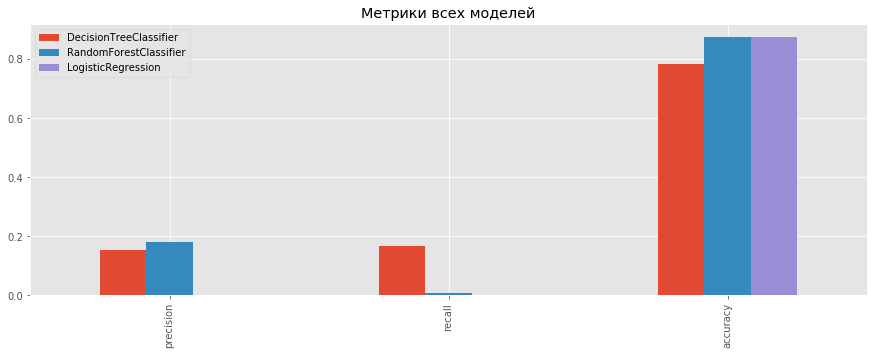

In [35]:
# Визуалищировать эти метрики всех моделей на одном графике (чтоб визуально сравнить)
# Возможно вас удивит качество! Но задача подобрана специально ;) Такое качество тоже бывает

## Your Code Here

from matplotlib import pyplot as plt


Metric_df = pd.DataFrame(data = {'DecisionTreeClassifier':[precision_score(y_test, predict_DTC), recall_score(y_test, predict_DTC), accuracy_score(y_test, predict_DTC)],
                                 'RandomForestClassifier':[precision_score(y_test, predict_RFC), recall_score(y_test, predict_RFC), accuracy_score(y_test, predict_RFC)],
                                 'LogisticRegression': [precision_score(y_test, predict_LR), recall_score(y_test, predict_LR), accuracy_score(y_test, predict_LR)]}, 
                         index=['precision', 'recall', 'accuracy'] )

Metric_df.plot(kind='bar',title = 'Метрики всех моделей', figsize=(15,5), legend=True)

LR 0.5921215178995176 DTC 0.5186219788483061 RFC 0.573133685714814


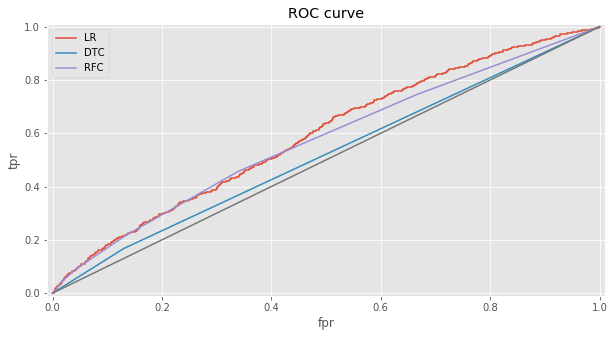

In [36]:
# Потроить roc-кривые всех можелей на одном графике
# Вывести roc_auc каждой моделе
# Подпишите оси и линии

## Your Code Here
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score_LR = roc_auc_score(y_test, predict_proba_LR[:,1])
roc_auc_score_DTC = roc_auc_score(y_test, predict_proba_DTC[:,1])
roc_auc_score_RFC = roc_auc_score(y_test, predict_proba_RFC[:,1])
print('LR',roc_auc_score_LR, 'DTC', roc_auc_score_DTC, 'RFC', roc_auc_score_RFC)

%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, predict_proba_LR[:,1])
fpr_DTC, tpr_DTC, thresholds_DTC = roc_curve(y_test, predict_proba_DTC[:,1])
fpr_RFC, tpr_RFC, thresholds_RFC = roc_curve(y_test, predict_proba_RFC[:,1])
plt.figure(figsize=(10, 5))
plt.plot(fpr_LR, tpr_LR, label = 'LR')
plt.plot(fpr_DTC, tpr_DTC, label = 'DTC')
plt.plot(fpr_RFC, tpr_RFC, label = 'RFC')
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.legend()

In [37]:
from sklearn.cross_validation import cross_val_score
# Сделать k-fold (10 фолдов) кросс-валидацию каждой модели
# И посчитать средний roc_auc

## Your Code Here
rfc = RandomForestClassifier()
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
cross_val_score_rfc = cross_val_score(
    dtc,
    X_test,
    y_test,
    scoring='roc_auc',
    cv=10
)
print('RandomForestClassifier кросс-валидация	', cross_val_score_rfc.mean())
cross_val_score_dtc = cross_val_score(
    rfc,
    X_test,
    y_test,
    scoring='roc_auc',
    cv=10
)
print('DecisionTreeClassifier кросс-валидация	', cross_val_score_dtc.mean())
cross_val_score_lr = cross_val_score(
    lr,
    X_test,
    y_test,
    scoring='roc_auc',
    cv=10
)
print('LogisticRegression кросс-валидация	', cross_val_score_lr.mean())

RandomForestClassifier кросс-валидация	 0.5141097584984905
DecisionTreeClassifier кросс-валидация	 0.5562957364186651
LogisticRegression кросс-валидация	 0.6042754909796312


In [38]:
# Взять лучшую модель и сделать предсказания (с вероятностями (!!!)) для test выборки

df_y_test = df_test_preproc['TARGET']
df_X_test = df_test_preproc.drop('TARGET', axis = 1)
# RandomForestClassifier()
model_RFС = RandomForestClassifier()
model_RFС.fit(df_X_test, df_y_test)                                 # обучаем модель
predict_RFC_test = model_RFС.predict(df_X_test)                      # делаем предсказание
predict_proba_RFC_test = model_RFС.predict_proba(df_X_test)              # вероятность

a = predict_RFC_test.tolist()
b = predict_proba_RFC_test[:,1].tolist()
df_test = pd.DataFrame(data = {'Предсказание': a, 'Вероятность':b})
df_test
## Your Code Here

,Предсказание,Вероятность
0,0,0.1
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,1,0.6
7,0,0.0
8,0,0.0
9,0,0.2


REF 0.9997918923625972


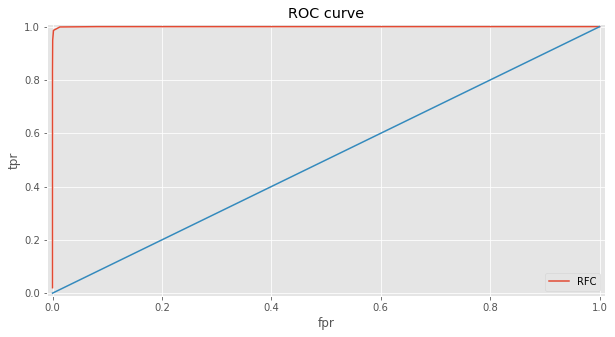

In [43]:
# Померить roc_auc на тесте
# Вывести текстом и на графике =)

## Your Code Here
roc_auc_score_RFC = roc_auc_score(df_y_test, predict_proba_RFC_test[:,1])
print('REF',roc_auc_score_RFC)

fpr_RFC, tpr_RFC, thresholds_RFC = roc_curve(df_y_test, predict_proba_RFC_test[:,1])
plt.figure(figsize=(10, 5))
plt.plot(fpr_RFC, tpr_RFC, label = 'RFC')
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.legend()

## Your Code Here

In [41]:
roc_auc_score_RFC = roc_auc_score(df_y_test, predict_proba_RFC_test[:,1])

### Больше обязательных заданий нет, но ниже вы можете провести исследование, поиграться с данными
### Это возможность написать код, который я посмотрю и в случае чего откомметирую. ;)
### Это не оценивается и остается на ваше усмотрение. Просто дополнительная возможность

In [ ]:
### И далее ;)